In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# El código siguiente recarga (reloads) las rutinas externas cada vez que el código cambia (es útil para "debuggear" código externo)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Método de Euler

Si nos permitimos un poco de _sloppiness_, podemos hacer lo siguiente:

$$
a \equiv\frac{dv}{dt}
$$

$$
dv = a dt
$$

Y reconociendo que tenemos números flotantes con precisión finita:

$$
\Delta v = a \Delta t
$$

Conociendo la posición inicial $x_i$ y el cambio $\delta x$ podemos estimar la nueva velocidad:

$$
v = v_i + a \Delta t
$$

Entonces, haciendo recursivos los _pasos_

$$
v_{i+1} = v_i + \frac{d}{dt}[v] \Delta t
$$

Y podemos hacer lo mismo para la posición:

$$
x_{i+1} = x_i + \frac{d}{dt}[x] \Delta t
$$

Una representación en imagen del método, se muestra a continuación:

<img src="images/euler_method.png">

<div class="alert alert-warning pull-right">
Imagen de Wikipedia
</div>

Como se puede apreciar en la figura, la aproximación con el _método de Euler_ va empeorando conforme aumentamos los pasos. Para combatir este error, se pueden disminuir el tamaño del paso, pero como veremos más adelante, esto tiene sus limitaciones.

## Ejemplo: Caída libre

La ecuación de movimiento en caída libre es:

$$
\ddot{x} = -g
$$

donde $g$ es la constante de gravedad.

El método de Euler sólo funciona con ecuaciones diferenciales de primer orden, pero podemos hacer el siguiente truco:

$$ 
\dot{x} = v
$$
$$
\dot{v} = -g
$$

Por lo que ahora nuestro sistema está descrito por dos ecuaciones lineales acopladas de primer orden.

El método de Euler nos dice que la solución de estas ecuaciones es:

$$
x_{i+1} = x_i + \dot{x} \Delta t
$$

$$ 
v_{i+1} = v_i + \dot{v} \Delta t
$$

El cual se puede escribir como

$$
y_{i+1} = y_i + \dot{y} \Delta t
$$

donde 

$$
y = 
\begin{bmatrix}
x \\
v
\end{bmatrix}
$$

y

$$
\dot{y} = 
\begin{bmatrix}
v \\
-g
\end{bmatrix}
$$


En python definimos una función para representar este sistema

In [ ]:
def caida_libre(estado, sistema):
    g0 = estado[1]
    g1 = -9.8
    
    return np.array([g0, g1])

In [ ]:
def euler(y, t, dt, derivadas):
    y_next = y + derivadas(y, t)*dt
    return y_next

In [ ]:
N = 1000 # número de pasos

x0 = 0.0  # posición inicial

v0 = 0.0  # velocidad inicial

g = -9.8 # aceleración de la gravedad en la tierra

tau = 3.0 # tiempo de la simulación
 
dt = tau/(float)(N-1)  # tamaño del paso

In [ ]:
time = np.linspace(0, tau, N)

In [ ]:
y = np.zeros([N,2])

y[0,0] = x0
y[0,1] = v0

In [ ]:
for j in range(N-1):
    y[j+1] = euler(y[j], time[j], dt, caida_libre)

In [ ]:
xdata = [y[j,0] for j in range(N)]
vdata = [y[j,1] for j in range(N)]

plt.plot(time, xdata, label="pos")
plt.plot(time, vdata, label="vel")
plt.xlabel("tiempo")
plt.ylabel("posicion, velocidad")
plt.legend(loc="best")

En el caso de la caída libre, es posible obtener una solución exacta:

$$
x(t) = x_i + v_i t + \frac{1}{2}g t^2
$$
$$
v(t) = v_i + gt
$$

In [ ]:
xt = lambda x_i, v_i, a, t: x_i + v_i*a + 0.5*a*t**2
vt = lambda v_i, a, t: v_i + a*t

plt.plot(time, xt(x0, v0, g, time), label="pos exacta")
plt.plot(time, vt(v0, g, time), label="vel exacta")
plt.plot(time, xdata, label="pos")
plt.plot(time, vdata, label="vel")
plt.legend(loc="best")

Al parecer en este caso no hay error (_perceptible_) en la diferenciación.

## Ejemplo: Péndulo simple

La ecuación de movimiento del péndulo es la siguiente:

$$
\frac{d^2\theta}{dt^2} = -\frac{g}{l}\sin\theta
$$

donde $\theta$ es el ángulo medido desde la vertical, $g$ es la aceleración debida a la gravedad y $l$ es la longitud del péndulo.

Esta ecuación es **no lineal** y la revisitaremos cuando veamos caos. 

Es posible linearizarla para el caso cuando $\theta$ es pequeño, en este caso $\sin\theta \approx \theta$

$$
\frac{d^2\theta}{dt^2} \approx -\frac{g}{l}\theta
$$

Esta ecuación de segundo orden se puede transformar en un sistema de ecuaciones de primer orden haciendo:

$$
\dot\theta = \omega
$$

$$
\dot\omega = - \frac{g}{l}\theta
$$

Una cantidad importante es la frecuencia

$$
\Omega = \sqrt\frac{g}{l}
$$

y su inverso el periodo

$$
T = \frac{2\pi}{\Omega}
$$

La energía total exacta $E$ del péndulo es:

$$
E = \frac{1}{2} m l^2 \omega^2 + m g l (1-\cos\theta)
$$

y en nuestra aproximación $\cos \theta \approx 1 - \theta^2/2$, entonces

$$
E \approx \frac{1}{2}ml^2\left ( \omega^2 + \frac{g}{l}\theta^2\right )
$$

Estamos definiendo la energía para poder evaluar el error de nuestro método de resolución de ecuaciones diferenciales.

La ecuación del péndulo, en nuestra aproximación, tiene una solución analítica:

$$
\theta(t) = \theta_i\cos(\Omega t) + \frac{\omega_i}{\Omega} \sin(\Omega t)
$$

In [18]:
masa = 1.0 # En kilogramos
longitud = 1.0 # En metros
g = 9.8 # m/s^2

Omega = np.sqrt(g/longitud)
periodo = 2*np.pi/Omega

In [19]:
def energia_pendulo(theta, omega, m = masa, g = g, l = longitud):
    return 0.5*m*l**2 * (omega**2 + (g/l)*theta**2)

In [86]:
def pendulo_analitico(t, theta, Omega, w):
    return theta*np.cos(Omega*t) + w*np.sin(Omega*t)/Omega

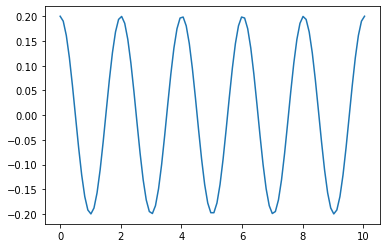

In [24]:
tau = 5*periodo

N = 100

dt = tau/(float)(N-1) 

tiempo = np.linspace(0, tau, num=N)

plt.plot(tiempo, pendulo_analitico(tiempo,0.2,Omega,0))

<div class="alert alert-info">
**Ejercicio:** Define una función `pendulo_analitico` que calcule en función del tiempo la posición del péndulo
</div>
<div class="alert alert-info">
**Ejercicio:** Grafica la solución analítica, con condiciones $\theta_i = 0.2$ y $\omega_i = 0$.
</div>

In [25]:
def pendulo_lineal(estado, tiempo, g=g, l=longitud):
    g0 = estado[1]
    g1 = -g/l*estado[0]
    return np.array([g0, g1])

In [26]:
tau = 5*periodo

N = 100

dt = tau/(float)(N-1) 

tiempo = np.linspace(0, tau, num=N)

y = np.zeros([N,2])

In [27]:
y[0,0] = 0.2
y[0,1] = 0.0

In [28]:
def pendulo_lineal_euler(y, tiempo, dt):

    for j in range(N-1):
        y[j+1] = euler(y[j], tiempo[j], dt, pendulo_lineal)

        
    theta = np.array([y[j,0] for j in range(N)])
    omega = np.array([y[j,1] for j in range(N)])
    
    return theta, omega

In [29]:
theta_euler, omega_euler = pendulo_lineal_euler(y, tiempo, dt)

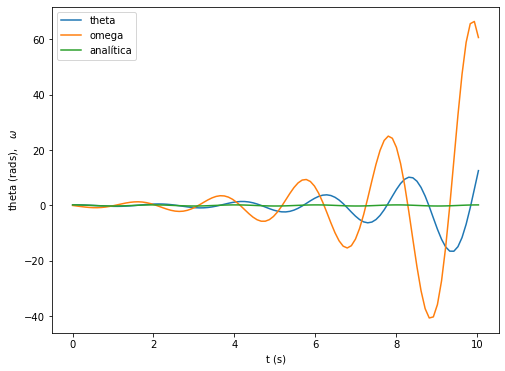

In [31]:
plt.figure(1, figsize=(8,6))
plt.plot(tiempo, theta_euler, label="theta")
plt.plot(tiempo, omega_euler, label="omega")
plt.plot(tiempo, pendulo_analitico(tiempo,0.2,Omega,0), label="analítica")
plt.xlabel(r"t (s)")
plt.ylabel(r"theta (rads),$\quad\omega$")
plt.legend(loc="best")

<div class="alert alert-info">
**Ejercicio:** Agrega en esta gráfica la solución analítica.
</div>

Mmmm... Creo que no se ve bien esto ¿Cómo se ve la energía?

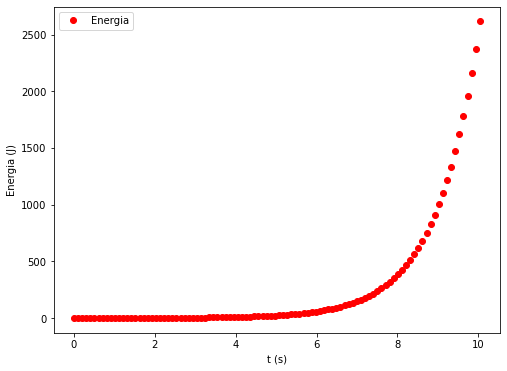

In [32]:
plt.figure(1, figsize=(8,6))
plt.plot(tiempo, energia_pendulo(theta_euler, omega_euler), marker='o', linestyle='None', color='red', label="Energia")
plt.xlabel(r"t (s)")
plt.ylabel(r"Energia (J)")
plt.legend(loc="best")

<div class="alert alert-info">
**Ejercicio**: ¿Por qué está mal la energía?
</div>
<div class="alert alert-info">
**Ejercicio**: Agrega un _widget_ para ver el número de paso $N$ (entre $1,000$ y $30,000$) ¿Qué sucede con la energia?
</div>

### Mejorando el código

Podemos mejorar el codigo si definimos los siguientes métodos:

In [73]:
class Pendulo:
    
    def __init__(self, masa, longitud, gravedad):
        self.masa = masa
        self.longitud = longitud
        self.gravedad = gravedad
      
        self.Omega = np.sqrt(g/longitud)
        self.period = 2*np.pi/Omega

        
    def theta(self):
        return self.trajectory[:,0]
    
    def omega(self):
        return self.trajectory[:,1]
    
    def plot(self):
        fig, ax = plt.subplots(3,1, figsize=(10,8), sharex = True)

        ax[0].plot(self.tau, self.theta(), label="theta", color="blue")
        ax[1].plot(self.tau, self.omega(), label="omega", color="green")
        ax[2].plot(self.tau, self.energy(),  marker='o', linestyle='None', color='red', label="Energia")

        ax[0].set_ylabel("Theta (rads)")
        ax[0].set_xlabel("tiempo (s)")

        ax[1].set_ylabel("Omega (rads/s)")
        ax[1].set_xlabel("tiempo (s)")

        ax[2].set_ylabel("Energia (J)")
        ax[2].set_xlabel("tiempo (s)")
    
    def initial_conditions(self, theta_i, omega_i):
        self.theta_i = theta_i
        self.omega_i = omega_i
        
    def dynamics(self, state, t):
        g0 = state[1]
        g1 = -self.gravedad/self.longitud*state[0]
        return np.array([g0, g1])
        
    def energy(self):
        return 0.5*self.masa*self.longitud**2 * (self.omega()**2 + (self.gravedad/self.longitud)*self.theta()**2)
        
    def integrate(self, num_steps, t_i, t_f, method):
        
        self.tau, self.dt = np.linspace(t_i, t_f, num=num_steps, retstep=True)
        self.trajectory = np.zeros([num_steps, 2])
        self.trajectory[0,0] = self.theta_i
        self.trajectory[0,1] = self.omega_i
        
        for j in range(N-1):
            self.trajectory[j+1] = method(self.trajectory[j], self.tau[j], self.dt, self.dynamics)        

#### Ejemplo de uso

In [74]:
p = Pendulo(masa = 1.0, longitud = 1.0, gravedad = 9.8)
p.initial_conditions(theta_i=0.2, omega_i=0.0)

In [75]:
N = 100
tiempo_inicial = 0.0
tiempo_final = 5*p.period

In [76]:
p.integrate(N, tiempo_inicial, tiempo_final, euler)

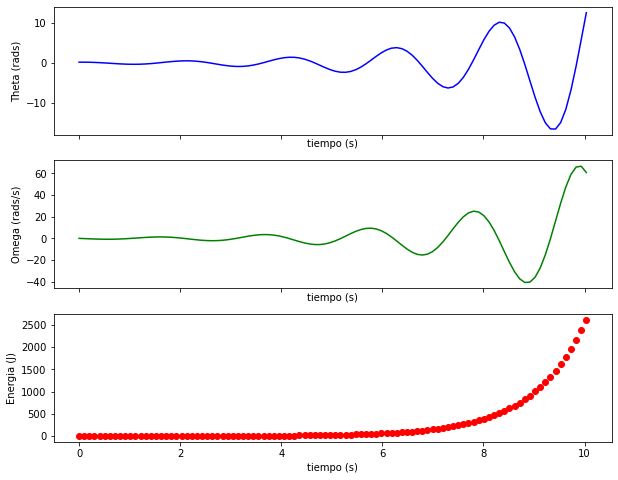

In [77]:
p.plot()

## Métodos de Runge-Kutta

In [78]:
def RK2(y, t, dt, derivadas):
    k0 = dt*derivadas(y, t)
    k1 = dt*derivadas(y + k0, t + dt)
    y_next = y + 0.5*(k0 + k1)
    
    return y_next

In [79]:
p2 = Pendulo(masa = 1.0, longitud = 1.0, gravedad = 9.8)
p2.initial_conditions(theta_i=0.2, omega_i=0.0)

In [80]:
N = 100
tiempo_inicial = 0.0
tiempo_final = 5*p2.period

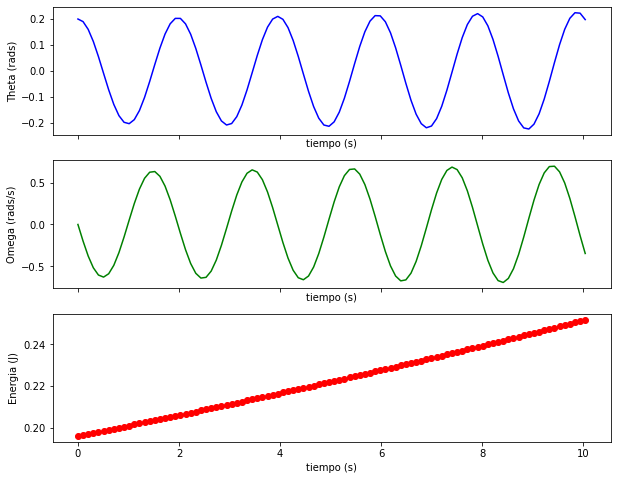

In [81]:
p2.integrate(N, tiempo_inicial, tiempo_final, RK2)
p2.plot()

<div class="alert alert-info">
**Ejercicio**: Crea una imagen donde se muestre la $\theta$ calculada con el método de Euler, RK2 y analítica. ¿Qué observas?
</div>

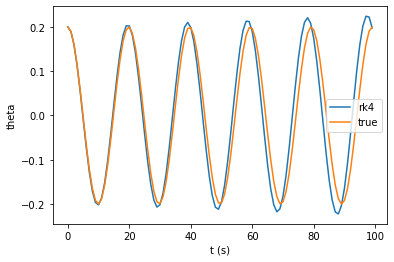

In [88]:
plt.plot(p2.trajectory[:,0], label='rk4')
#plt.plot(p.trajectory[:,0], label='euler')
plt.plot(pendulo_analitico(tiempo,0.2,Omega,0), label='true')
plt.xlabel(r"t (s)")
plt.ylabel(r"theta")
plt.legend(loc="best")


## Diagrama de fase

Text(0, 0.5, 'omega (rads/s)')

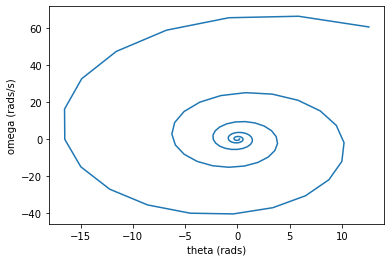

In [89]:
plt.plot(p.theta(), p.omega())
plt.xlabel("theta (rads)")
plt.ylabel("omega (rads/s)")

Text(0, 0.5, 'omega (rads/s)')

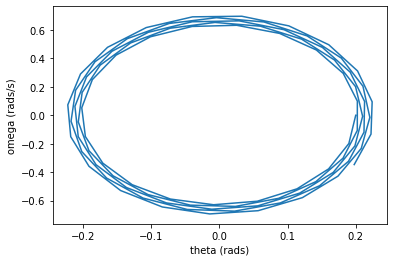

In [90]:
plt.plot(p2.theta(), p2.omega())
plt.xlabel("theta (rads)")
plt.ylabel("omega (rads/s)")

<div class="alert alert-info">
**Ejercicio**: Agregue el método para dibujar el diagrama de fase a la clase `Pendulo`
</div>

<div class="alert alert-info">
**Ejercicio**: Cree un archivo `pendulo_linealizado.py` y guarde ahí la clase. Cárguelo a la sesión.
</div>

<div class="alert alert-info">
**Ejercicio**: Modifique el método `dynamics` para el caso en que no está linealizado el péndulo, i.e.

$$
\ddot\theta = -\frac{g}{l} \sin\theta
$$

Grafique los diagramas con el método Runge - Kutta de 2do Orden. Guardelo en el archivo `pendulo_real.py`
</div>

<div class="alert alert-info">
**Ejercicio**: Modifique el método `dynamics` para el caso en que no está linealizado el péndulo, exista un amortiguamiento y ademas haya una fuerza externa, como se muestra en la siguiente ecuación.

$$
\ddot\theta = -\frac{g}{l} \sin\theta - \beta\dot\theta + A \cos(\omega t)
$$

Grafique los diagramas con el método Runge - Kutta de 2do Orden. Guárdelo en el archivo `pendulo_actuado.py`
</div>

## Métodos de Scipy

`Scipy` implementa una rutina que resuelve ecuaciones diferenciales, `odeint()` del paquete `scipy.integrate`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [ ]:
odeint?

Como puedes observar se puede invocar con la función `dynamics`, un arreglo que represente el estado inicial y un `array` de tiempos (en lugar de un _time step_).

### Ejemplo: Péndulo con resorte

una masa $m$ está sujeta a un resorte con constante elástica $k$, el resorte a su vez está pegado al techo. La longitud del resorte sin deformar es $L_0$, y el ángulo respecto a la vertical es $\theta$.  Usando ecuaciones de [Euler-Lagrange](http://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation), se encuentra que las ecuaciones de movimiento son:

$$
\ddot{L} = (L_0 + L)\dot{\theta}^2 - \frac{k}{m}L + g \cos\theta
$$

$$
\ddot\theta = - \frac{1}{L_0+L} \left[ g\sin\theta + 2\dot{L}\dot{\theta}\right]
$$

<div class="alert alert-info">
**Ejercicio** Escribe este par de ecuaciones como un sistema de ecuaciones de primer orden
</div>

In [ ]:
N = 1000

# Constantes
L_0 = 1.0
L = 1.0
v_i = 0.0
theta_i = 0.3
omega_i = 0.0

k = 3.5 # COnstante del resorte en N/m
m = 0.2 # masa en kilogramos
g = 9.8 # Constante de gravedad terrestre, en m/s^2

In [ ]:
# Estado inicial
y = np.zeros([4])
y

In [ ]:
# Estado inicial
y[0] = L
y[1] = v_i
y[2] = theta_i
y[3] = omega_i

In [ ]:
y

In [ ]:
time = np.linspace(0,25,N)

<div class="alert alert-info">
**Ejercicio** Escribe el sistema de ecuaciones en el método `pendulo_con_resorte(estado, tiempo)`
</div>

In [ ]:
def pendulo_con_resorte(estado, tiempo):
    g0 = 0
    g1 = 0
    g2 = 0
    g3 = 0
    return np.array([g0,g1,g2,g3])

In [ ]:
solucion = odeint(func=pendulo_con_resorte, y0 = y, t = time)

Dibujaremos el movimiento en el espacio físico euclídeo 2D $(x, y)$, para esto, necesitamos convertir a estas coordenadas en lugar usando las fórmulas trigonométricas.

In [ ]:
xdata = (L_0 + solucion[:,0])*np.sin(solucion[:,2])
ydata = -(L_0 + solucion[:,0])*np.cos(solucion[:,2])

In [ ]:
plt.plot(xdata, ydata, 'r-')
plt.xlabel("Posicion Horizontal")
plt.ylabel("Posicion Vertical")

<div class="alert alert-info">
**Ejercicio**: Dibuja respecto al tiempo el valor de $L$ y de $\theta$.
</div>

<div class="alert alert-info">
**Ejercicio** Resuelve el péndulo amortiguado, grafica en el espacio euclídeo y también la posición respecto al tiempo. La ecuación del péndulo amortiguado es:

$$
\ddot\theta = - \frac{g}{L}\sin\theta -b\dot\theta + \beta\cos(\omega t)
$$
</div>